# Introduction

[Speech Data Explorer](https://github.com/NVIDIA/NeMo/tree/main/tools/speech_data_explorer) (SDE) is a visual tool for interactive exploration of speech datasets and error analysis of Automatic Speech Recognition (ASR) models. This tutorial demonstrates how to use SDE in Comparison mode to evaluate two ASR models on a given test set and identify differences in their predictions.

# Installation

First, let's install NeMo:

In [ ]:
BRANCH = 'main'

!git clone -b $BRANCH https://github.com/NVIDIA/NeMo

!apt-get update && apt-get install -y libsndfile1 ffmpeg
!cd NeMo;./reinstall.sh
!apt-get install sox

!pip3 install -r ./NeMo/tools/speech_data_explorer/requirements.txt

# Dataset

In this tutorial we use LibriSpeech test-other dataset to evaluate ASR models. Let's download and prepare the dataset.

In [ ]:
!python3 ./NeMo/scripts/dataset_processing/get_librispeech_data.py --data_sets test_other --data_root .

Before starting SDE, we need to run ASR inference on a given dataset and save predictions into a JSON manifest.


It is assumed that you already have a JSON manifest  containing the `audio_filepath` and reference `text` fields. Here is a minimal example:

```
{
    "audio_filepath": "/LibriSpeech/dev-clean-processed/2902-9008-0000.wav",
    "text": "the place seemed fragrant with all the riches of greek",
}
```

# Transcription

To compare two models, JSON file should contain predictions from 1st (e.g., `QuartzNet15x5`) and 2nd (e.g., `Conformer-CTC Small`) models.

NeMo includes a Python script for ASR inference: [`transcribe_speech.py`](https://github.com/NVIDIA/NeMo/blob/main/examples/asr/transcribe_speech.py).

`transcribe_speech.py` accepts `append_pred` flag that allows saving an ASR transcript in the JSON file with a given custom field (like `pred_text_QN`). `pred_name_postfix` parameter defines the custom field's name. In this example it is set to the abbreviated model name `QN`.

In [ ]:
!python3 ./NeMo/examples/asr/transcribe_speech.py \
pretrained_name="QuartzNet15x5Base-En" \
dataset_manifest=./test_other.json \
output_filename="test_other_QN.json" \
batch_size=8 \
timestamps=False \
compute_langs=False \
cuda=0 amp=True \
append_pred=True \
pred_name_postfix="QN"

`transcribe_speech.py` also reports overall WER for the given dataset. In our case, QuartzNet's WER is 10.0%.

Here is the first line of the newly created `test_other_QN.json` manifest file with QuartzNet's predictions:

In [ ]:
!head -n 1 test_other_QN.json

Let's run inference with the second ASR model (`Conformer-CTC Small`):

In [ ]:
!python ./NeMo/examples/asr/transcribe_speech.py \
pretrained_name="stt_en_conformer_ctc_small" \
dataset_manifest=./test_other_QN.json \
output_filename="test_other_QN_Conf_small.json" \
batch_size=8 \
timestamps=False \
compute_langs=False \
cuda=0 amp=True \
append_pred=True \
pred_name_postfix="conf_s"

Conformer's WER  is 8.1%.

Here is the first line of `test_other_QN_Conf_small.json` manifest file with transcripts by both ASR models
- `pred_text_QN` by QuartzNet
- `pred_text_conf_s` by Conformer-Small

In [ ]:
!head -n 1 test_other_QN_Conf_small.json

# Launching SDE

Now it's time to start SDE!

SDE is a Python web application that can be run either locally or on a remote server (a cloud instance) from a command line.

In this tutorial, we use Google Colab. So we need to get a proxy link to the instance:

In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(8050)"))

Now let's start SDE with the following shell command. `nc` parameter provides names of ASR transcripts for Comparison mode.

In [ ]:
!python3 ./NeMo/tools/speech_data_explorer/data_explorer.py test_other_QN_Conf_small.json --port=8050 \
-nc pred_text_QN pred_text_conf_s

Please click on the aforementioned proxy link to view SDE application in another web-browser tab.

#Quick guide on SDE interface

SDE provides general dataset's statistics (number of utterances, hours, character set size, histograms, etc.) on `Statistics` page. It allows users to do interactive exploration and analysis on the dataset on `Samples` page. All these functions are described in detail in [NeMo documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tools/speech_data_explorer.html).

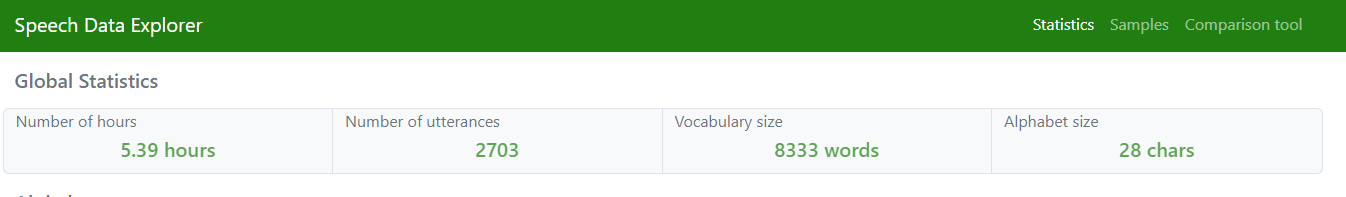

In this tutorial, we are interested in `Comparison tool` page.

The `Comparison` page has two main modes (levels) of comparison:
- word level (metrics for individual vocabulary words are compared)
- utterance level (metrics for individual dataset's utterances are compared)

In each mode, the dataset is visualized as an interactive scatterplot. Each marker represents a data unit (either a word, or an utterance). X-coordinate encodes a selected metric for one model, Y-coordinate does the same for the other model.

By default, word level comparison is selected on `Comparison tool` page. In second (2) and third (3) box you can choose what will be shown on the axes of the scatterplot (that is, metrics for 1st and 2nd models). In our example, it is word level accuracy for QuartzNet and Conformer-Small: `accuracy_model_pred_text_{model_name}`.

Depending on comparison level, these fields provide the following options:


*   word accuracy (ratio of the correctly recognized number of words to the total number of this word in the entire dataset)
*   utterance WER
*   utterance CER

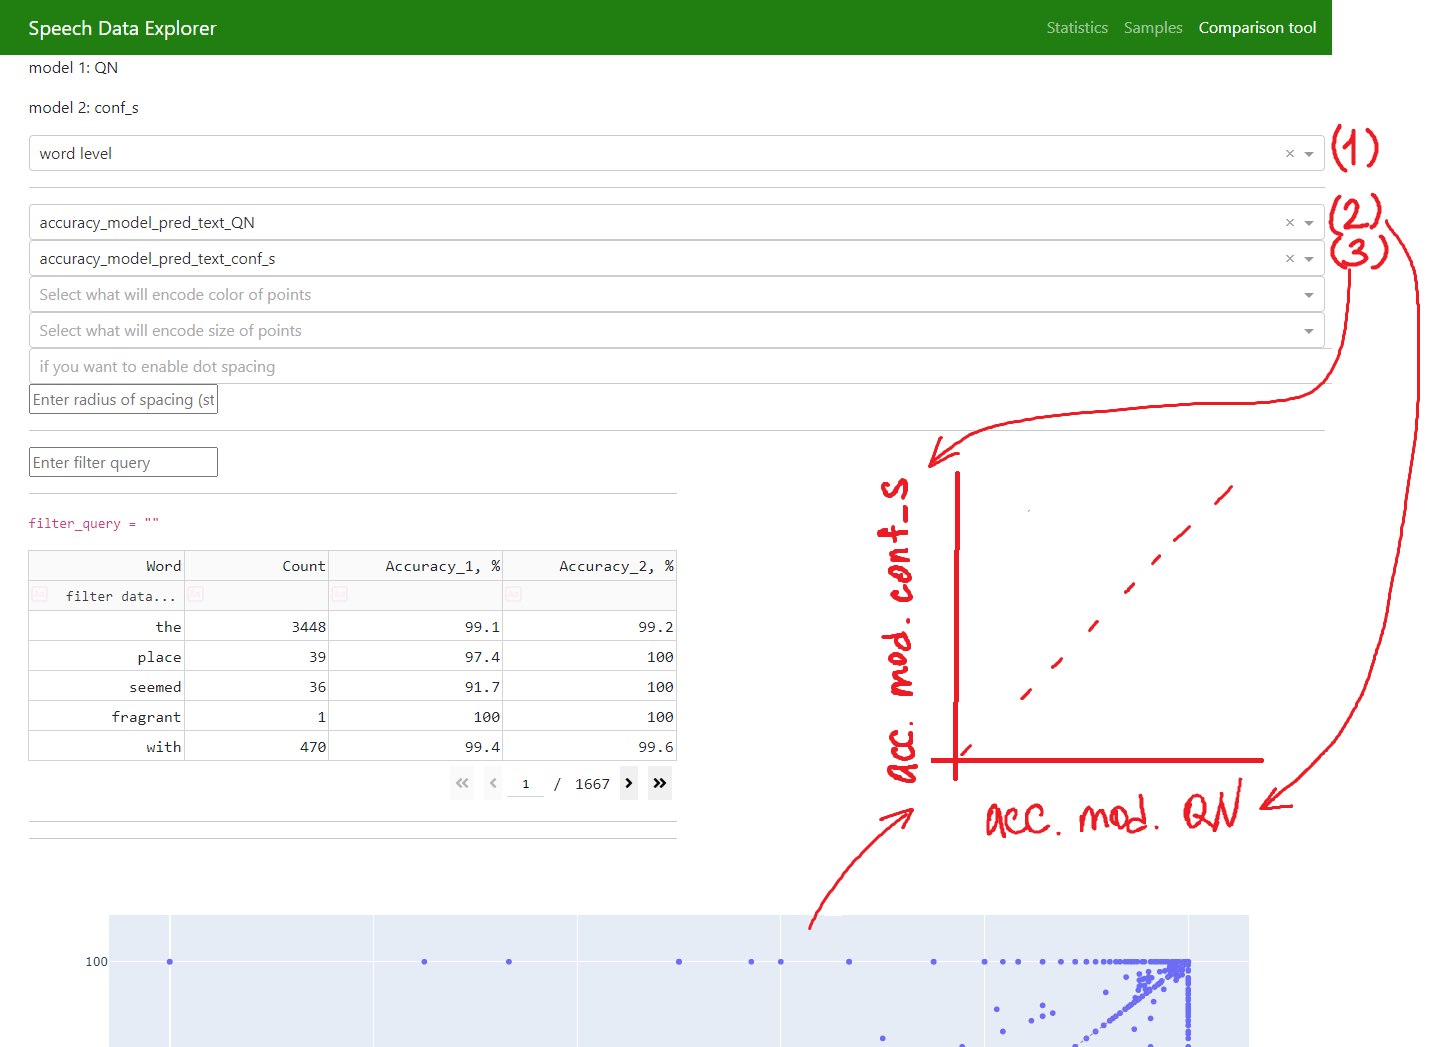

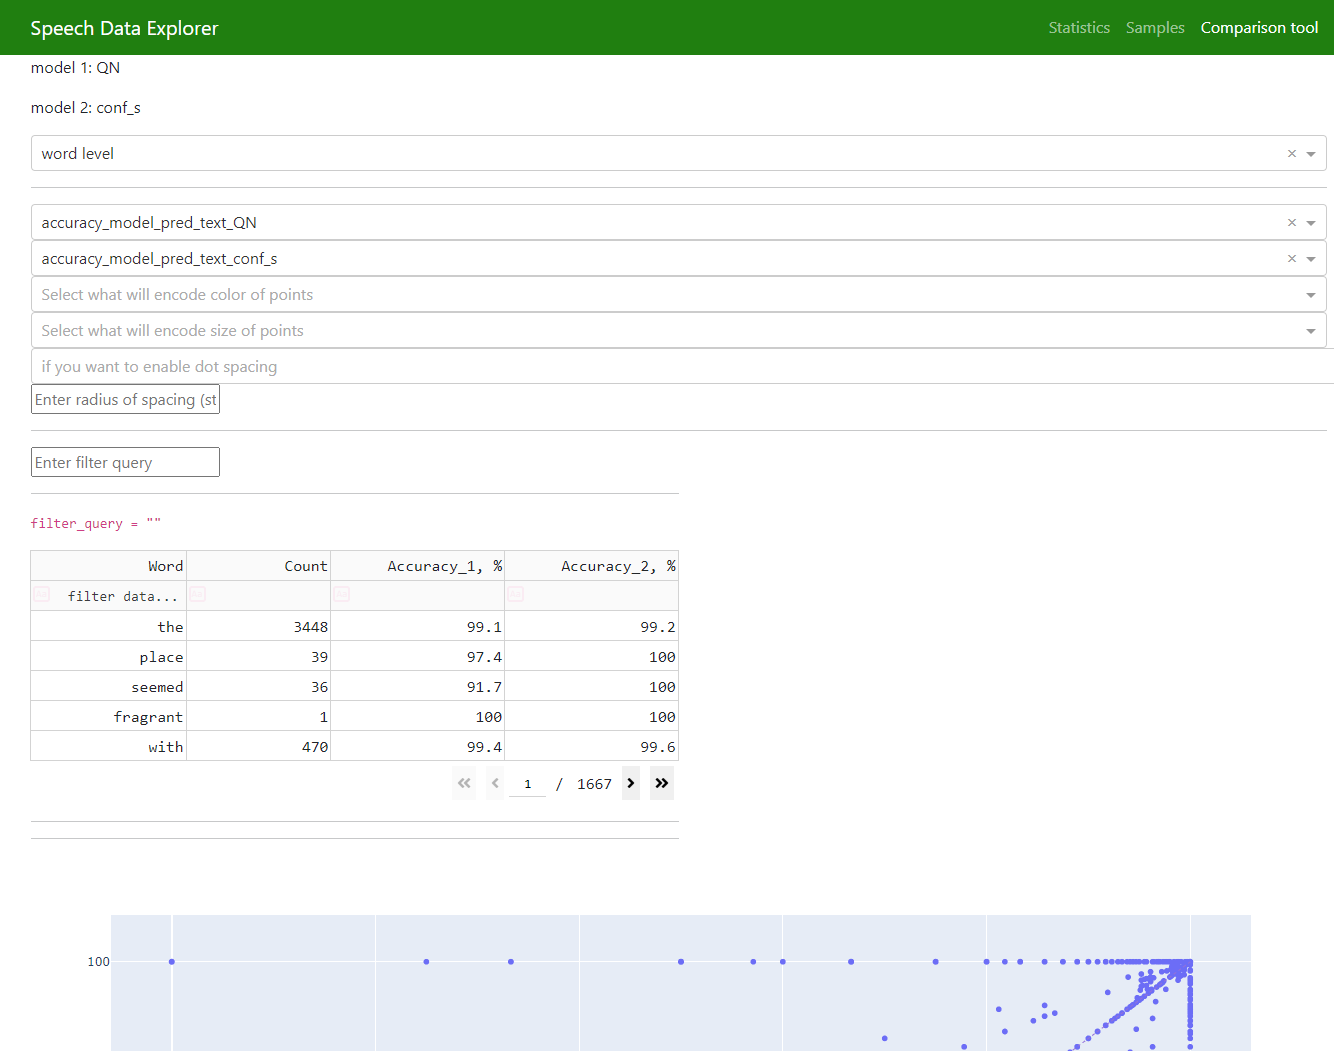

By default, the scatterplot displays all data units (either words or utterances). To allow users to select more interesting subsets, SDE supports flexible filtering queries like in the following example (for word level):


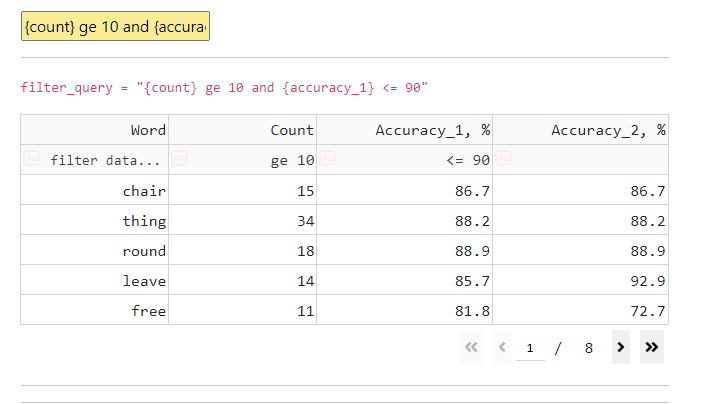

You can type the filtering queries either in a specific column header, or in a custom filter expression textbox (putting lowercased column names in curly brackets).




Below is an example of complicated query, that allows us to display utterances where both ASR models yield different WERs (for utterance level):

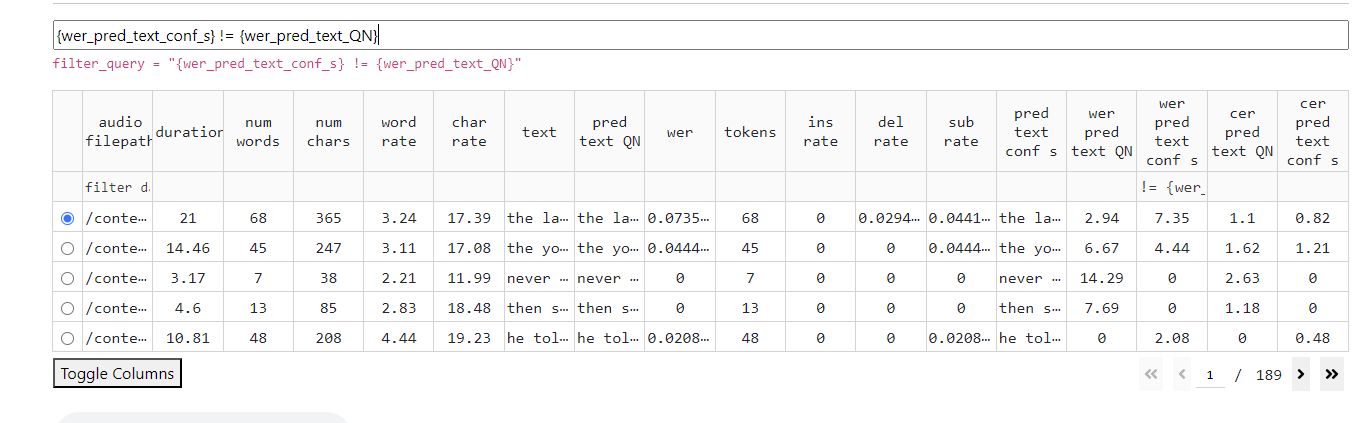

The scatterplot is fully interactive: you can zoom, swipe, and view extended information about a data point hovering over it.

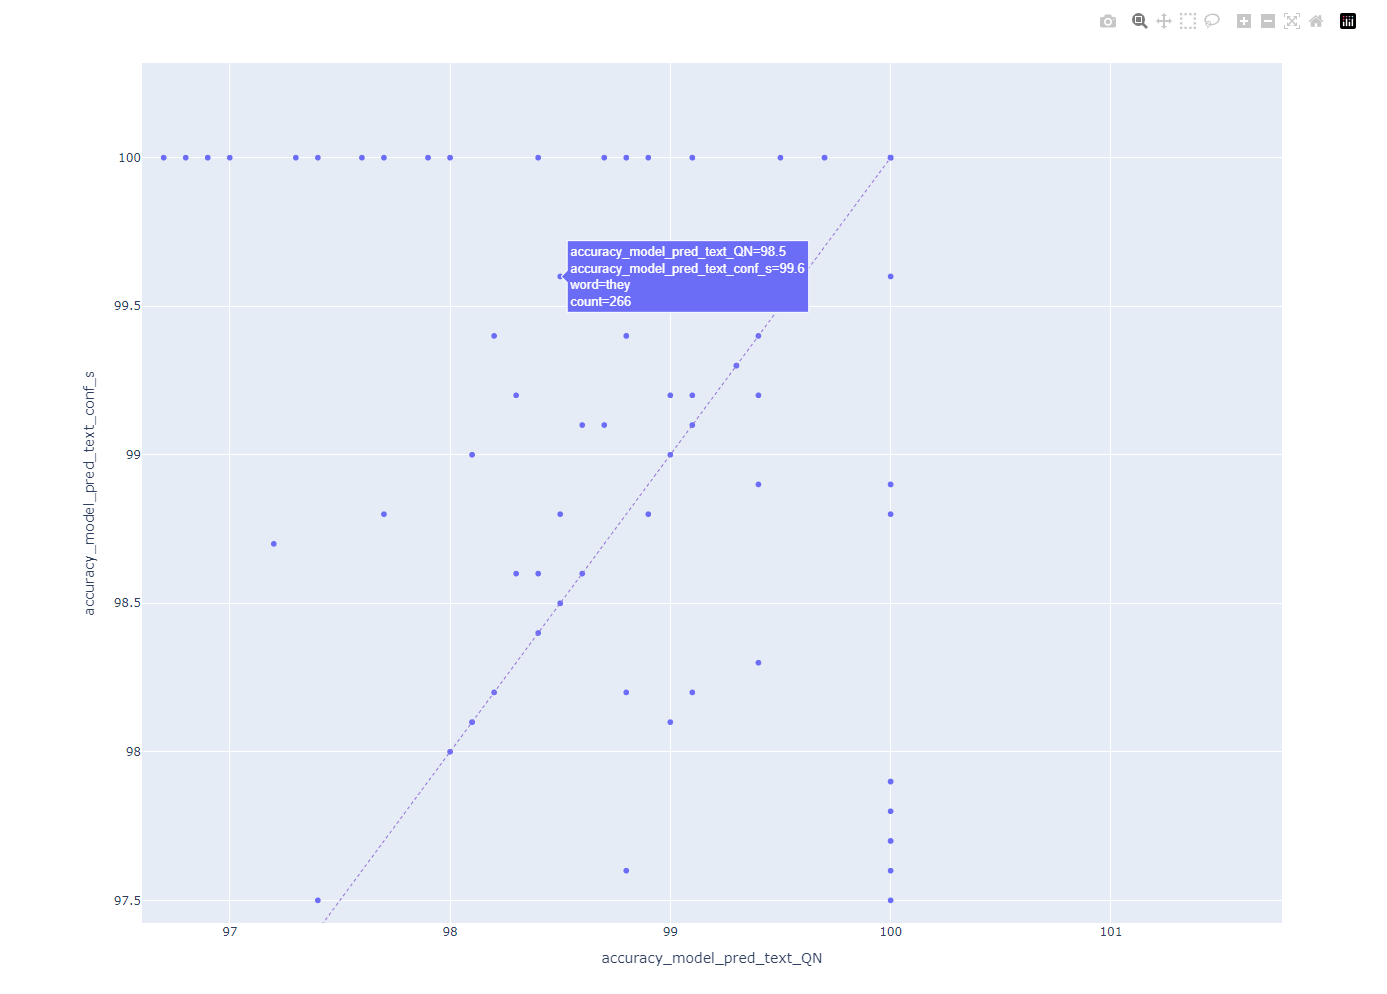

Let's examine an utterance level mode.

You can choose either WER or CER as a metric:

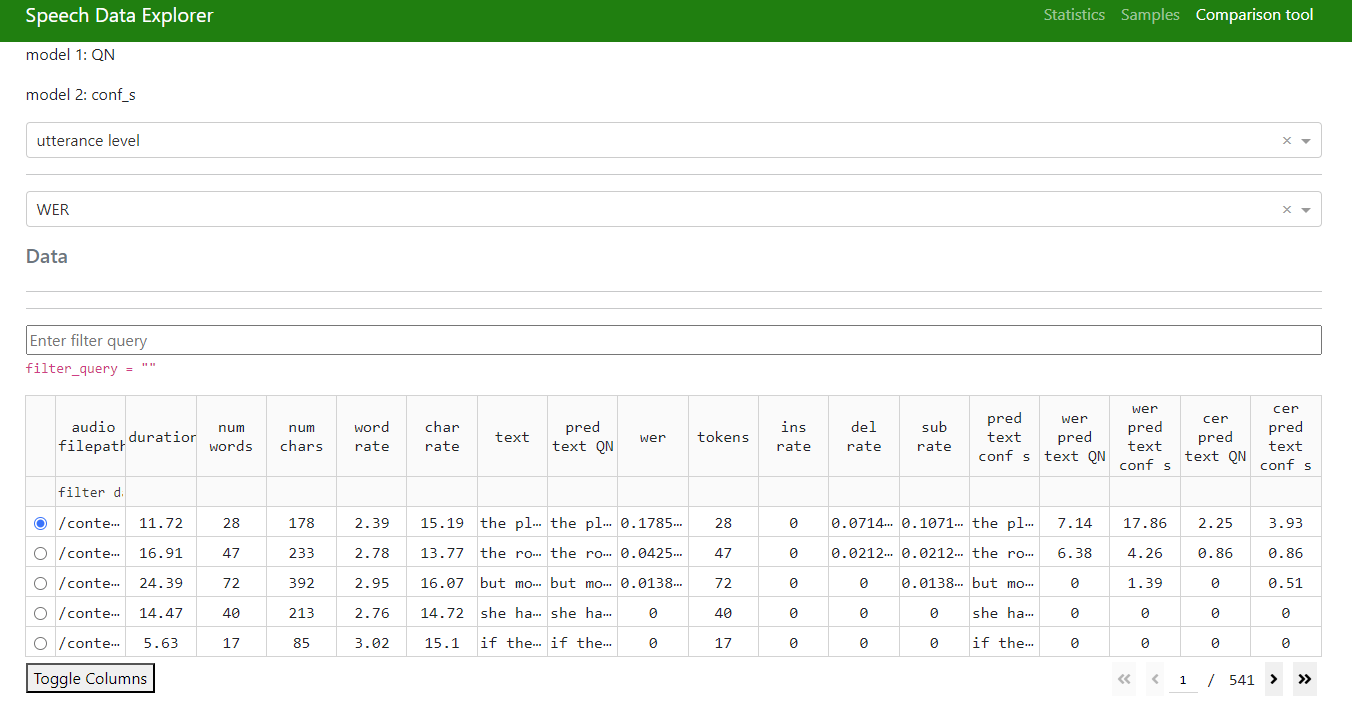

It is easy to add complex filtering expressions:

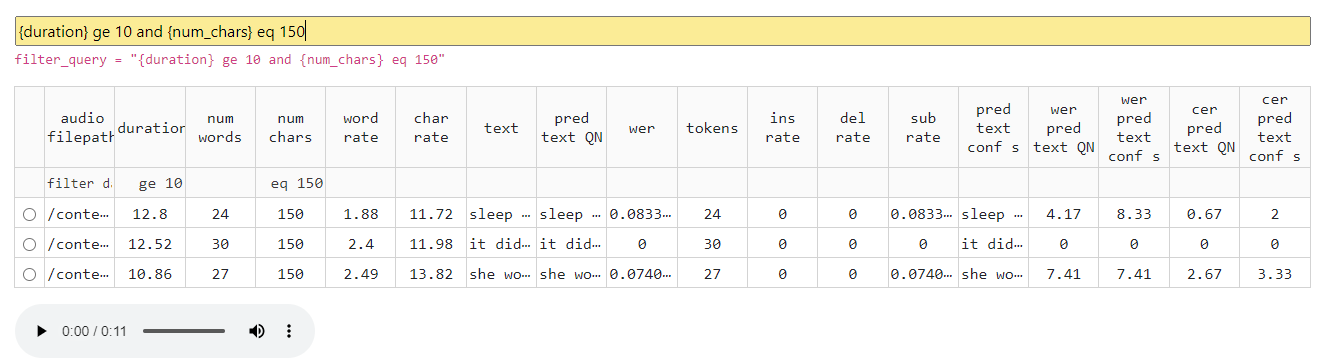

The scatterplot is interactive. Clicking on any data point automatically selects corresponding data row in dataset table.

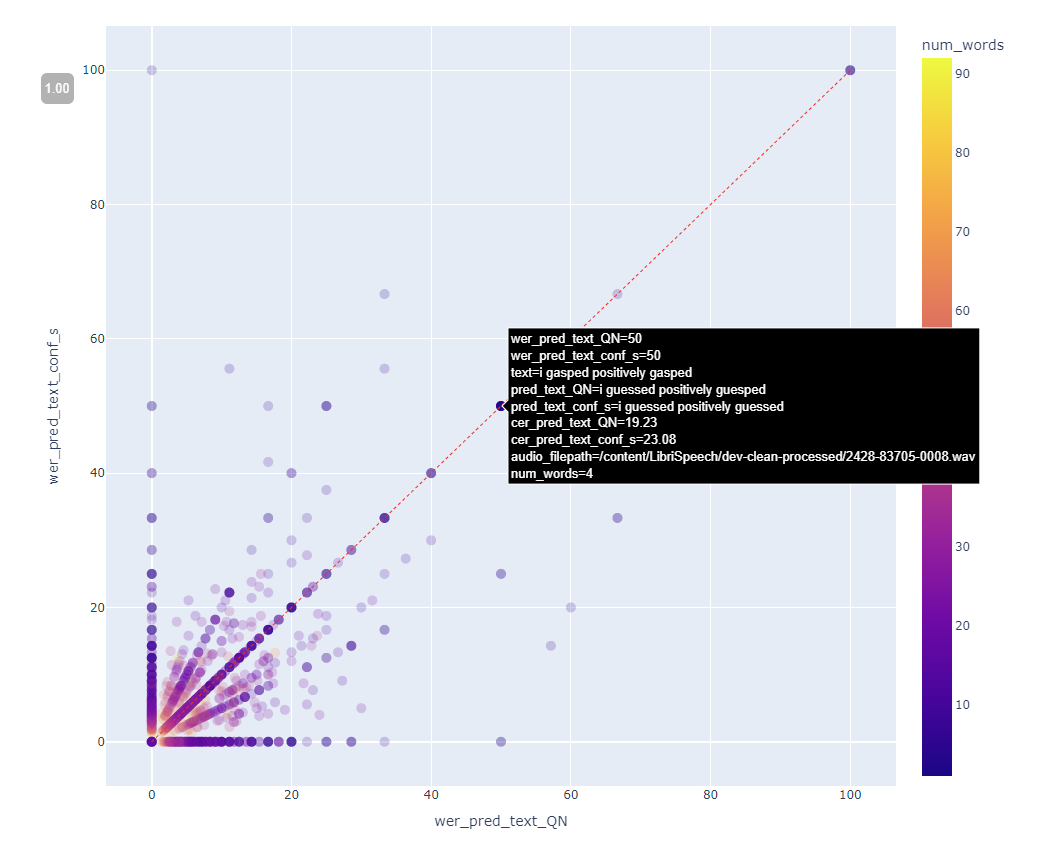

After selecting a data point, you can listen to the utterance. Just click on player icon.

Also you can analyze audio signal in time and frequency domain using interactive plots of the signal and its spectrogram.


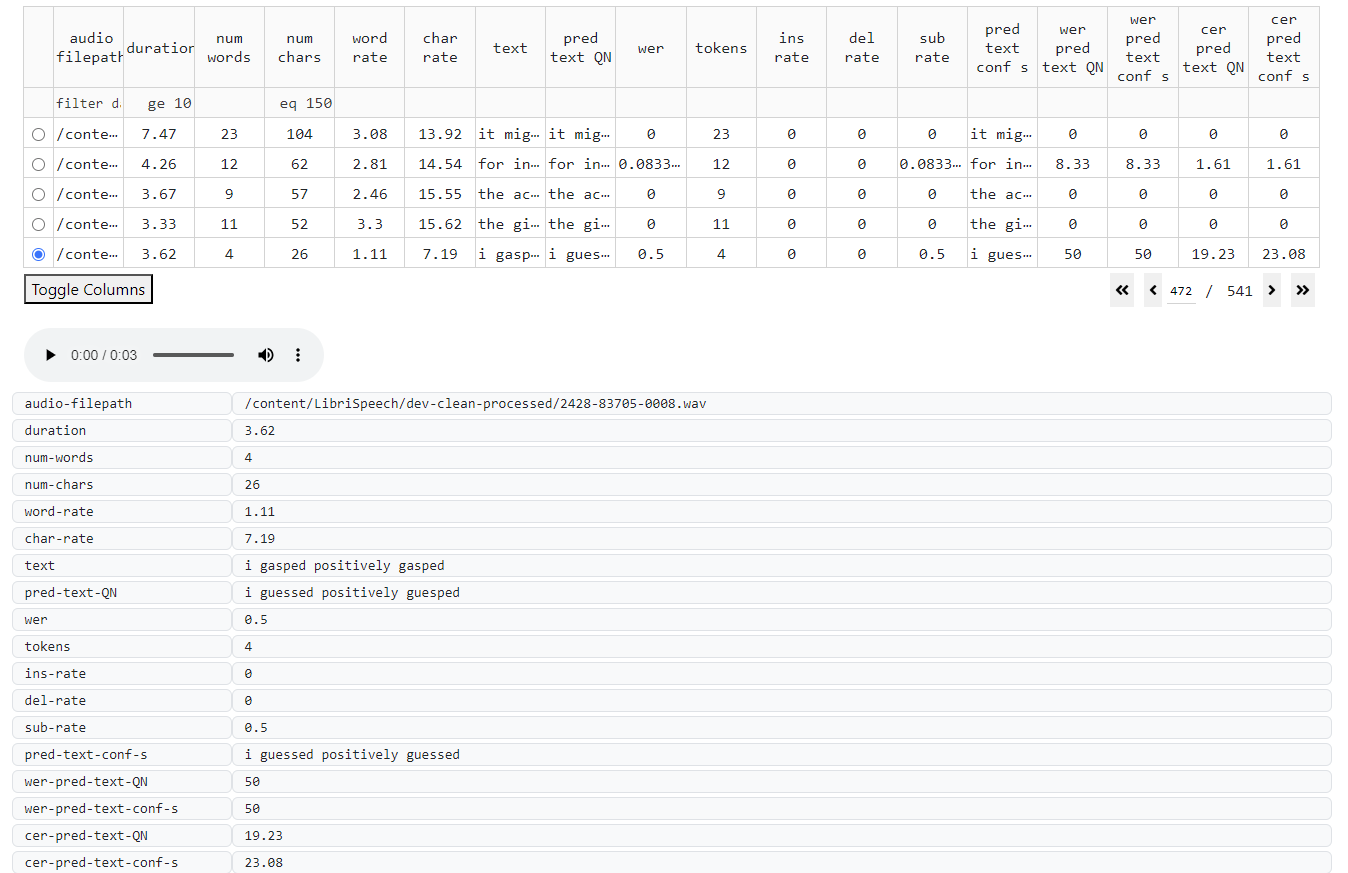

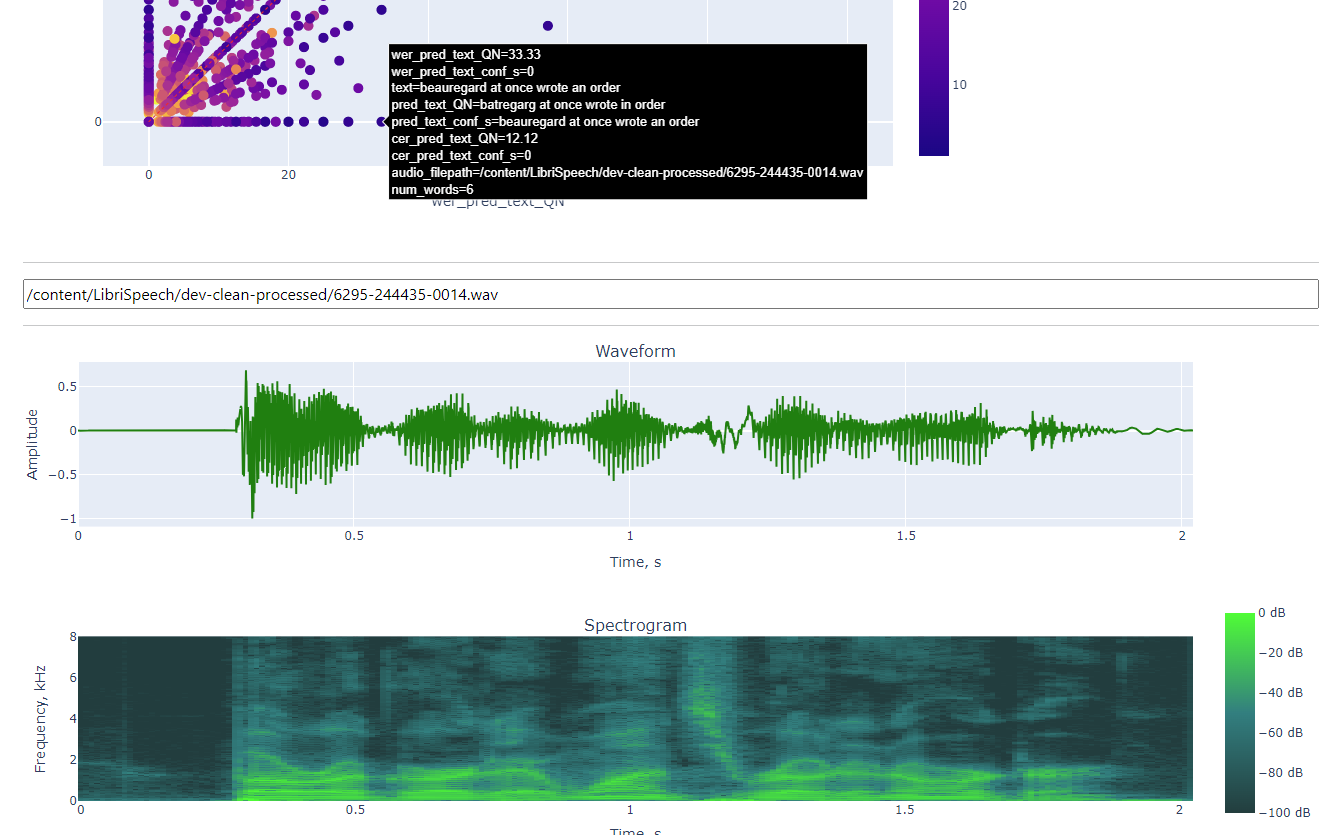

# Interesting examples and use cases

Using the {wer_model_1} != {wer_model_2} query you can remove all sentences/words that have the same WER, this can be very convenient if the models you are comparing are similar.

In the following example, you can see how QuartzNet and Conformer-Small transcribe the same utterance:

*   reference transcript is `the school of the wilderness`
*   QuartzNet's transcript is `the school of the wearerness` (the error in the last word)
*   Conformer-Small's transcript is `the score of the word in its` (almost completely wrong prediction)



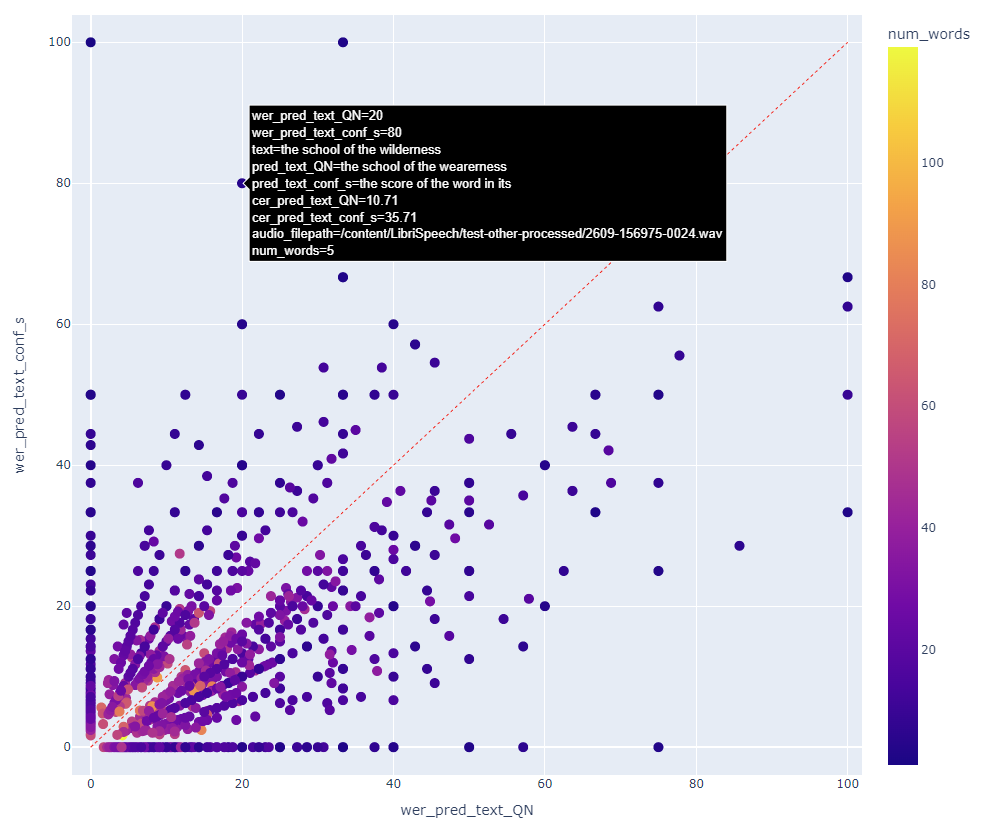

General ASR models might make mistakes in proper nouns and narrow domain specific terms since they are rarely found in training datasets.

1) Name: `Shiloh`

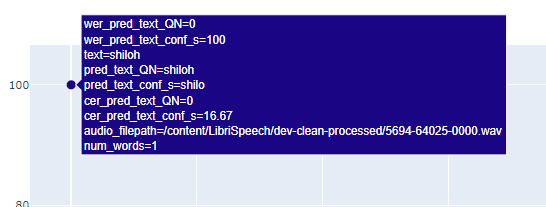

2) Domain specific term: `rheumatic`

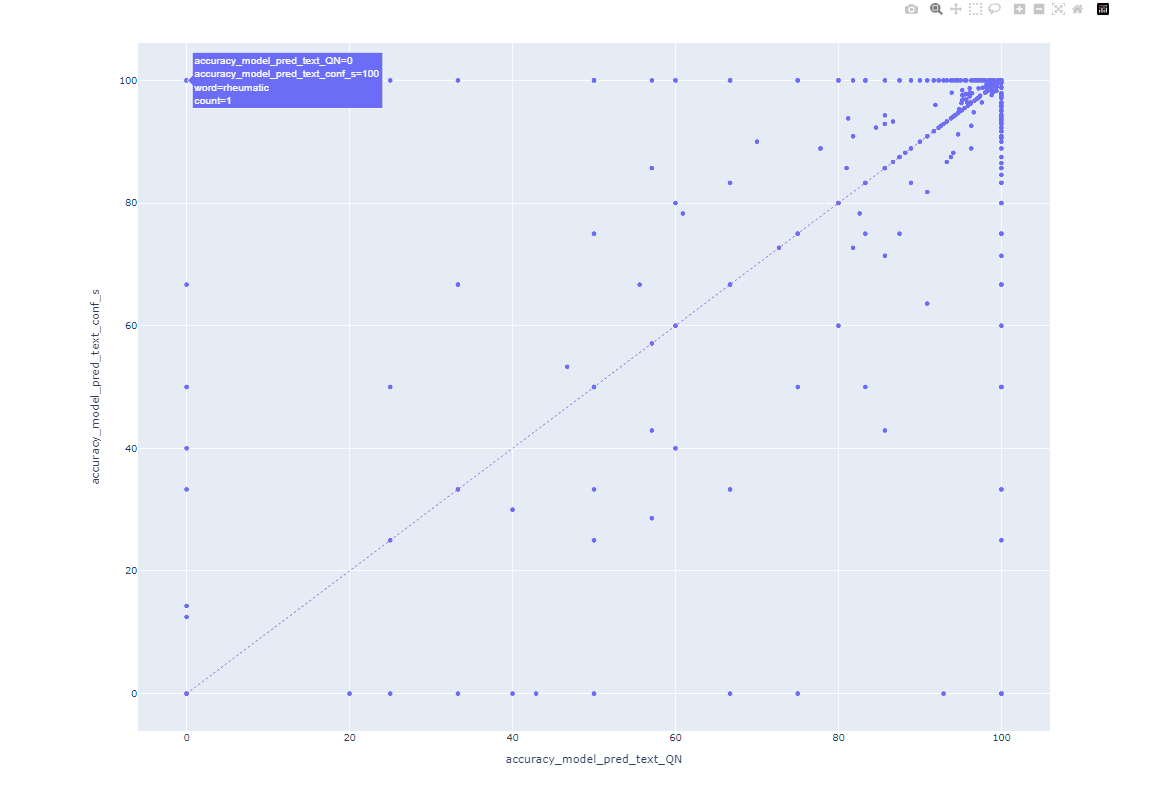

It is very likely that, in the word level mode, many words will receive the same accuracy, and will overlap with each other on the scatterplot. That is why the graph will display only one point at a given location. To resolve this issue, there is an option to space them with a given radius:

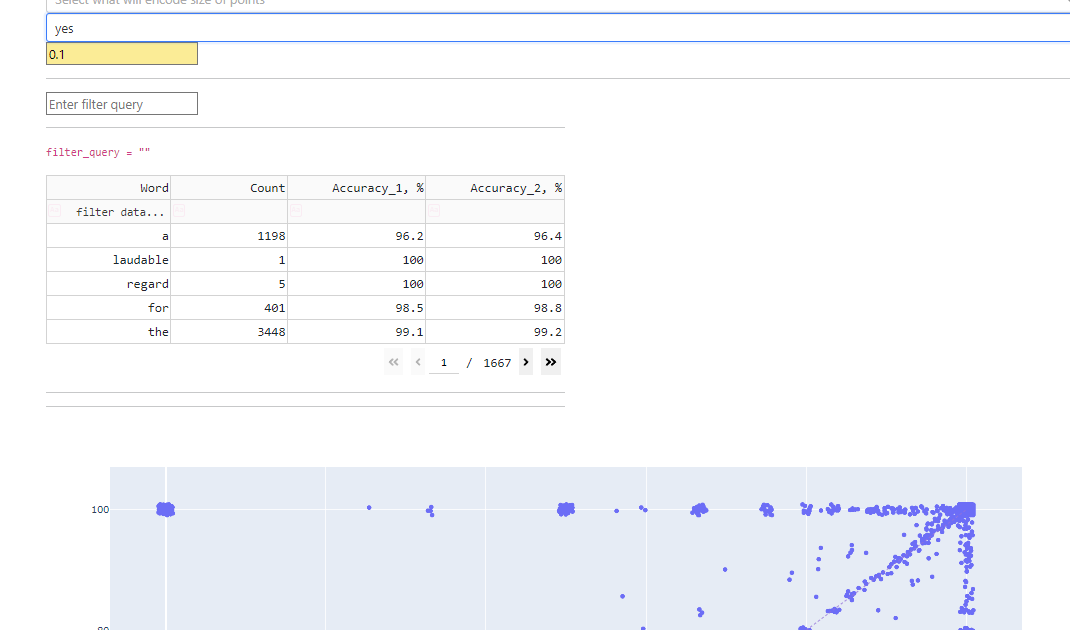

This part of the graph shows an enlarged view in coordinates (0, 100). That is, words correctly recognized by the Conformer-Small and not recognized by QuartzNet.

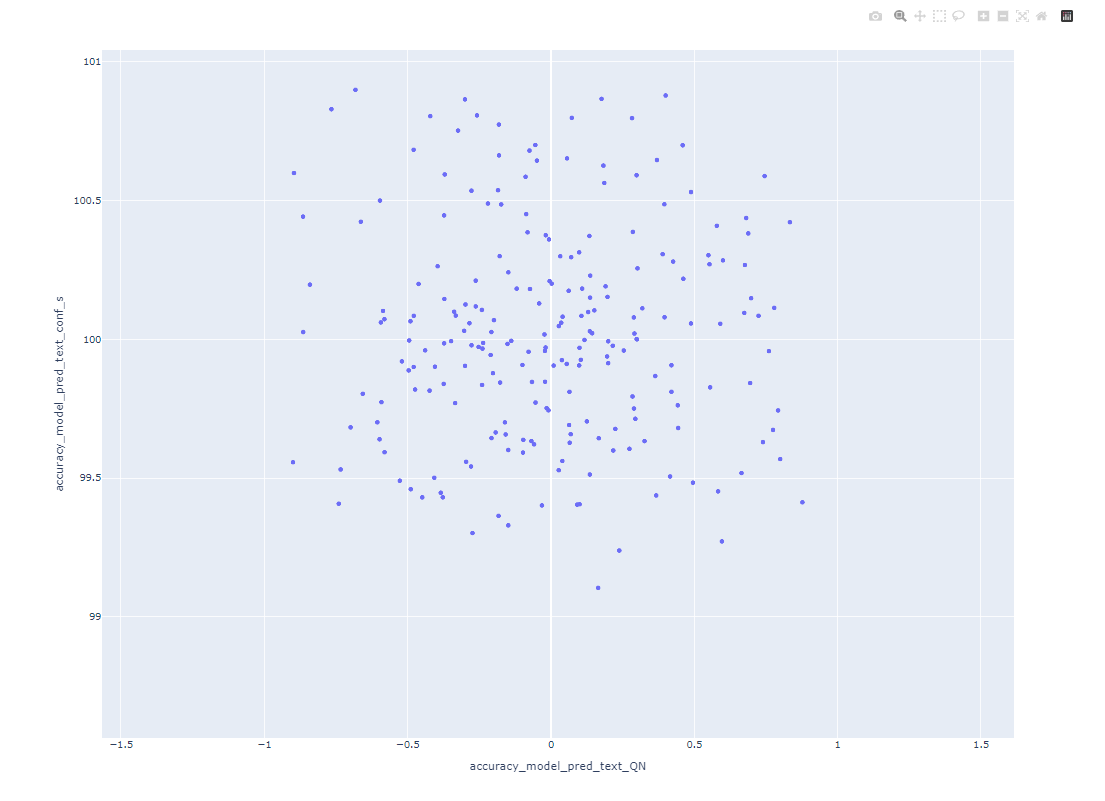

Let's write down words recognized only by QuartzNet and words recognized only by Conformer-Small:

In [ ]:
import pandas as pd

data = {
    "QuartzNet_words": ["allspice", "southwark", "dante", "panada", "favour", "vapours", "fuchs", "battlefields", "morrel", "postscript"],
    "Conformer_words": ["gothic", "tablespoons", "heidelberg", "bough", "nocturnal", "meekin", "-", "-", "-", "-"]
}

df = pd.DataFrame(data)

df



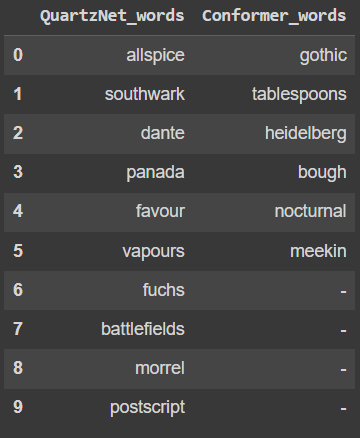

Words in the first group seem to have varied origins, with a mix of English, Germanic, and potentially Latin-derived terms.
The second group, on the other hand, also appears to contain words of varied linguistic origins but might have a slightly more European or Old World feel, especially with words like `gothic` and `heidelberg`.

**Word Length**

The average word length in the first group might be longer with words like `battlefields` and `postscript`.
The second group also contains long words, but when we consider `bough` or `gothic`, it might have a slightly shorter average length.

**Functional vs. Descriptive**

The first group contains a mix of nouns that are both functional (like `allspice` or `panada`) and more abstract or descriptive (like `dante` or `vapours`).
The second group also contains nouns, but they seem more descriptive or pertaining to concepts or themes like `gothic` or `nocturnal`.

Next, we will look at several interesting examples that were easily discovered using this tool.

# Examples with audio

(It is worth noting that the examples below are taken from LibriSpeech dev-clean set, while the rest of the tutorial is based on LibriSpeech test-other)

In [ ]:
#This cell is made so that you can quickly listen to those utterances.
from IPython.display import Audio, display
!python3 ./NeMo/scripts/dataset_processing/get_librispeech_data.py --data_sets dev_clean --data_root .

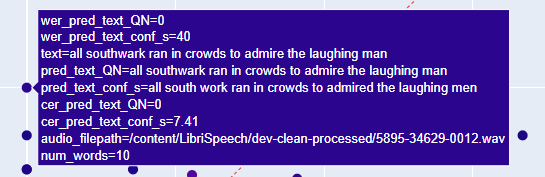

Above is example how Conformer-Small trying to use more common phrases fails with recognizing word `southwark` (Southwark is a district of Central London). We see how Conformer-Small fails on proper nouns and just names in general.

In [ ]:
sound_file = "/content/LibriSpeech/dev-clean-processed/5895-34629-0012.wav"
display(Audio(sound_file, autoplay=True))

In this case, the speaker does not really pause between `over` and `all`, and QuartzNet transcribes it as a single word.

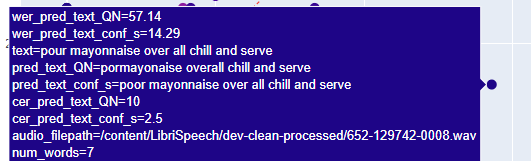

In [ ]:
sound_file = "/content/LibriSpeech/dev-clean-processed/652-129742-0008.wav"
display(Audio(sound_file, autoplay=True))

This is an example of an error in the dataset.
The audio is challenging (quality is not very good, and the speaker is singing this phrase). But it is obvious that the reference transcript should be `grub pile grub pile`. Likely, the extra space in word `pile` was introduced by replacing a hyphen character with a space in the original dataset:

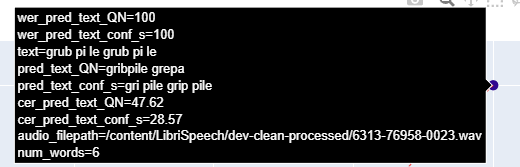

In [ ]:
sound_file = "/content/LibriSpeech/dev-clean-processed/6313-76958-0023.wav"
display(Audio(sound_file, autoplay=True))

Here is another example. I would not say that the models were wrong. When listening to the audio, you might actually think that the announcer is saying “guessed”.

Therefore, if we see that both models make the same errors - this is a good reason to check the dataset.

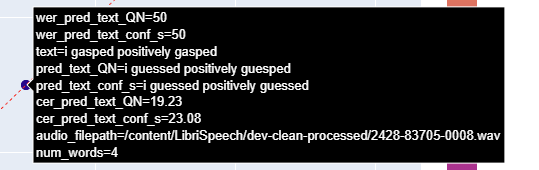

In [ ]:
sound_file = "/content/LibriSpeech/dev-clean-processed/2428-83705-0008.wav"
display(Audio(sound_file, autoplay=True))